## 附件

交叉验证策略

[Scikit-learn validator](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

[Cross-validation for time series](https://robjhyndman.com/hyndsight/tscv/)

[Ordered cross-validation](https://github.com/MaxHalford/xam/blob/master/docs/model-selection.md#ordered-cross-validation)

[Cross-Validation Methodology Using '16 Golden Week](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/45266)

## import part

In [1]:
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

%matplotlib inline

## Init

In [2]:
data = {
    'tra': pd.read_csv('./data/air_visit_data.csv'),
    'as': pd.read_csv('./data/air_store_info.csv'),
    'hs': pd.read_csv('./data/hpg_store_info.csv'),
    'ar': pd.read_csv('./data/air_reserve.csv'),
    'hr': pd.read_csv('./data/hpg_reserve.csv'),
    'id': pd.read_csv('./data/store_id_relation.csv'),
    'tes': pd.read_csv('./data/sample_submission.csv'),
    'hol': pd.read_csv('./data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

# 初始处理:
#       1. 从tes数据id中提取air_store_id和visit_datetime
#       2. 在HPG预订信息中匹配air_store_id
#       2. 转换visit_datetime和reserve_datetime为时间格式
print("Init.")
# 1.
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
# 2.
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])
# 3.
for k in data:
    if 'visit_date' in data[k].columns:
        data[k]['visit_date'] = pd.to_datetime(data[k]['visit_date'])
    if 'visit_datetime' in data[k].columns:
        data[k]['visit_date'] = pd.to_datetime(data[k]['visit_datetime'].str.split().str[0])
        data[k].drop('visit_datetime', axis=1, inplace=True)
    if 'reserve_datetime' in data[k].columns:
        data[k]['reserve_date'] = pd.to_datetime(data[k]['reserve_datetime'].str.split().str[0])
        data[k].drop('reserve_datetime', axis=1, inplace=True)


Init.


## 定义特征抽取函数

In [3]:
# count / ratio
# data['tra'].groupby('air_store_id')['visitors'].sum()
def time_feats(df, dt_col='visit_date'):
    df[dt_col] = pd.to_datetime(df[dt_col])
    df.loc[:, 'year'] = df[dt_col].dt.year
    df.loc[:, 'dow'] = df[dt_col].dt.dayofweek
    df.loc[:, 'month'] = df[dt_col].dt.month
    # df.loc[:, 'season'] = df[dt_col].dt.quarter
    df.loc[:, 'week'] = df[dt_col].dt.weekofyear
    df.loc[:, 'doy'] = df[dt_col].dt.dayofyear
    df.loc[:, 'date_int'] = df[dt_col].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
    return 1

# 增加时间特征
time_feats(data['tra'])
time_feats(data['tes'])

# 匹配genre和area信息
data['tra'] = data['tra'].merge(data['as'][['air_store_id', 'air_genre_name', 'air_area_name']], how='left', on='air_store_id')
data['tes'] = data['tes'].merge(data['as'][['air_store_id', 'air_genre_name', 'air_area_name']], how='left', on='air_store_id')

# 匹配holiday信息
data['tra'] = data['tra'].merge(data['hol'].drop('day_of_week', axis=1), how='left', on='visit_date')
data['tes'] = data['tes'].merge(data['hol'].drop('day_of_week', axis=1), how='left', on='visit_date')

###  PART1. Count & Agg

In [4]:
# Store
# 1. overall
store_agg_all = data['tra'].groupby('air_store_id')['visitors'].agg([
    np.min, np.mean, np.median, np.max, np.std, np.sum])

# 2. monthly data
store_cnt_monthly = data['tra'].groupby(['air_store_id', 'year', 'month'])['visitors'].sum().to_frame().reset_index()  # 过程数据
store_mean_std_monthly = store_cnt_monthly.groupby('air_store_id')['visitors'].agg([np.mean, np.std])
store_agg_monthly = store_cnt_monthly.groupby(['air_store_id', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
store_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']
store_agg_monthly.loc[:, 'ratio_m'] = store_agg_monthly['mean_m'] / store_mean_std_monthly['mean']

# 3. weekly data
store_cnt_weekly = data['tra'].groupby(['air_store_id', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()  # 过程数据
store_mean_std_weekly = store_cnt_weekly.groupby('air_store_id')['visitors'].agg([np.mean, np.std])
store_agg_weekly = store_cnt_weekly.groupby(['air_store_id', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
store_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']
store_agg_weekly.loc[:, 'ratio_w'] = store_agg_weekly['mean_w'] / store_mean_std_weekly['mean']

# 4. dow data
# 构建原始的store_agg_dow
unique_stores = data['tra']['air_store_id'].unique()
store_agg_dow = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i] * len(unique_stores), 'holiday_flg': [j] * len(unique_stores)})
                           for i in range(7) for j in range(2)],
                           axis=0, ignore_index=True).reset_index(drop=True)

store_agg_all = data['tra'].groupby('air_store_id')['visitors'].agg([
    np.min, np.mean, np.median, np.max, np.std, np.sum])

# 辅助表1: 不考虑holiday_flg的聚合数据
store_agg_dow_all = data['tra'].groupby(['air_store_id', 'dow'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size])
store_agg_dow_all.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
store_agg_dow_all.loc[:, 'ratio_d'] = store_agg_dow_all['mean_d'] / store_agg_all['mean']

# 辅助表2: 考虑holiday_flg的聚合数据
store_agg_dow_hol = data['tra'].groupby(['air_store_id', 'dow', 'holiday_flg'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size]).fillna(0)
store_agg_dow_hol.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
# store_agg_dow_hol.loc[:, 'ratio_d'] = store_agg_dow_hol['mean_d'] / store_agg_all['mean']
store_agg_dow_hol.loc[:, 'ratio_d'] = store_agg_dow_hol['mean_d'] / store_agg_all['mean']

# 匹配 air_store_id, dow, holiday_flg 聚合数据
store_agg_tmp = store_agg_dow.merge(store_agg_dow_hol, how='left', left_on=['air_store_id', 'dow', 'holiday_flg'], right_index=True)

# 匹配air_store_id, dow, holiday_flg留下的空值，用air_store_id, dow匹配
store_agg_tmp1 = store_agg_tmp.loc[store_agg_tmp.drop(['air_store_id', 'dow', 'holiday_flg'], axis=1).isnull().all(axis=1)][['air_store_id', 'dow', 'holiday_flg']]
# store_agg_tmp1 = store_agg_tmp1.merge(store_agg_dow_all, how='left', left_on=['air_store_id', 'dow'], right_index=True)
store_agg_tmp1 = store_agg_tmp1.merge(store_agg_dow_all, how='left', left_on=['air_store_id', 'dow'], right_index=True)

# 匹配air_store_id, dow留下的空值，用air_store_id匹配
store_agg_tmp2 = store_agg_tmp1.loc[store_agg_tmp1.drop(['air_store_id', 'dow', 'holiday_flg'], axis=1).isnull().all(axis=1)][['air_store_id', 'dow', 'holiday_flg']]
store_agg_tmp2 = store_agg_tmp2.merge(store_agg_all.drop('sum', axis=1), how='left', left_on='air_store_id', right_index=True)
store_agg_tmp2 = store_agg_tmp2.merge(store_agg_dow_all.groupby('air_store_id')['len_d'].mean().to_frame(), how='left', left_on='air_store_id', right_index=True)
store_agg_tmp2['ratio_d'] = 1
store_agg_tmp2.columns = ['air_store_id', 'dow', 'holiday_flg', 'min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d', 'ratio_d']
# 从store_agg_tmp中剔除store_agg_tmp1, 从store_agg_tmp1中剔除store_agg_tmp2
store_agg_tmp.drop(store_agg_tmp1.index, inplace=True)
store_agg_tmp1.drop(store_agg_tmp2.index, inplace=True)

store_agg_dow = pd.concat([store_agg_tmp, store_agg_tmp1, store_agg_tmp2])
store_agg_dow.set_index(['air_store_id', 'dow', 'holiday_flg'], inplace=True)

# 5. penetration
store_penetration = (data['tra'].groupby('air_store_id')['visitors'].sum() / data['tra']['visitors'].sum()).to_frame('penet_store')

comment = '''
store_agg_all                    --> <index> air_store_id,            <cols> sum, mean, std
store_mean_std_monthly --> <index> air_store_id             <cols> mean, std
store_agg_monthly          --> <index> air_store_id, month <cols> min_m, mean_m, median_m, max_m, ratio_m
store_mean_std_weekly   --> <index> air_store_id,             <cols> mean, std
store_agg_weekly            --> <index> air_store_id, week    <cols> min_w, mean_w, median_w, max_w, ratio_w
store_agg_dow                --> <index> air_store_id, dow      <cols> min_d, mean_d, median_d, max_d, std_d, len_d, ratio_d
store_penetration            --> <index> air_store_id               <cols> penet_store
'''

In [5]:
# Genre
# 1. overall
genre_agg_all = data['tra'].groupby('air_genre_name')['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
genre_cnt_monthly = data['tra'].groupby(['air_genre_name', 'year', 'month'])['visitors'].sum().to_frame().reset_index()
genre_mean_std_monthly = genre_cnt_monthly.groupby('air_genre_name')['visitors'].agg([np.mean, np.std])
genre_agg_monthly = genre_cnt_monthly.groupby(['air_genre_name', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']
genre_agg_monthly.loc[:, 'ratio_m'] = genre_agg_monthly['mean_m'] / genre_mean_std_monthly['mean']

# 3. weekly data
genre_cnt_weekly = data['tra'].groupby(['air_genre_name', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()
genre_mean_std_weekly = genre_cnt_weekly.groupby('air_genre_name')['visitors'].agg([np.mean, np.std])
genre_agg_weekly = genre_cnt_weekly.groupby(['air_genre_name', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']
genre_agg_weekly.loc[:, 'ratio_w'] = genre_agg_weekly['mean_w'] / genre_mean_std_weekly['mean']

# 4. dow data
genre_agg_dow = data['tra'].groupby(['air_genre_name', 'dow'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size])
genre_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
genre_agg_dow.loc[:, 'ratio_d'] = genre_agg_dow['mean_d'] / genre_agg_all['mean']

# 5. penetration
genre_penetration = (data['tra'].groupby('air_genre_name')['visitors'].sum() / data['tra']['visitors'].sum()).to_frame('penet_genre')

comment = '''
genre_agg_all                    --> <index> air_genre_name,              <cols> sum, mean, std
genre_mean_std_monthly --> <index> air_genre_name               <cols> mean, std
genre_agg_monthly          --> <index> air_genre_name, month   <cols> min_m, mean_m, median_m, max_m, ratio_m
genre_mean_std_weekly   --> <index> air_genre_name,               <cols> mean, std
genre_agg_weekly            --> <index> air_genre_name, week      <cols> min_w, mean_w, median_w, max_w, ratio_w
genre_agg_dow                --> <index> air_genre_name, dow       <cols> min_d, mean_d, median_d, max_d, std_d, len_d, ratio_d
genre_penetration            --> <index> air_genre_name                <cols> penet_genre
'''


In [6]:
# Area
# 1. overall
area_agg_all = data['tra'].groupby('air_area_name')['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
area_cnt_monthly = data['tra'].groupby(['air_area_name', 'year', 'month'])['visitors'].sum().to_frame().reset_index()
area_mean_std_monthly = area_cnt_monthly.groupby('air_area_name')['visitors'].agg([np.mean, np.std])
area_agg_monthly = area_cnt_monthly.groupby(['air_area_name', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
area_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']
area_agg_monthly.loc[:, 'ratio_m'] = area_agg_monthly['mean_m'] / area_mean_std_monthly['mean']

# 3. weekly data
area_cnt_weekly = data['tra'].groupby(['air_area_name', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()
area_mean_std_weekly = area_cnt_weekly.groupby('air_area_name')['visitors'].agg([np.mean, np.std])
area_agg_weekly = area_cnt_weekly.groupby(['air_area_name', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
area_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']
area_agg_weekly.loc[:, 'ratio_w'] = area_agg_weekly['mean_w'] / area_mean_std_weekly['mean']

# 4. dow data
area_agg_dow = data['tra'].groupby(['air_area_name', 'dow'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max, np.std, np.size])
area_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
area_agg_dow.loc[:, 'ratio_d'] = area_agg_dow['mean_d'] / area_agg_all['mean']

# 5. penetration
area_penetration = (data['tra'].groupby('air_area_name')['visitors'].sum() / data['tra']['visitors'].sum()).to_frame('penet_area')

comment = '''
area_agg_all                    --> <index> air_area_name,              <cols> sum, mean, std
area_mean_std_monthly --> <index> air_area_name               <cols> mean, std
area_agg_monthly          --> <index> air_area_name, month   <cols> min_m, mean_m, median_m, max_m, ratio_m
area_mean_std_weekly   --> <index> air_area_name,               <cols> mean, std
area_agg_weekly            --> <index> air_area_name, week      <cols> min_w, mean_w, median_w, max_w, ratio_w
area_agg_dow                --> <index> air_area_name, dow       <cols> min_d, mean_d, median_d, max_d, std_d, len_d, ratio_d
area_penetration            --> <index> air_area_name                <cols> penet_area
'''


In [7]:
# genre X area
# data['tra']['air_area_name1'] = data['tra']['air_area_name'].apply(lambda x: x.split()[0].split('-')[0])
# data['tra']['air_area_name2'] = data['tra']['air_area_name'].apply(lambda x: ' '.join(x.split()[:2]))

# 1. overall count
genre_area_cnt_all = data['tra'].groupby(['air_genre_name', 'air_area_name'])['visitors'].agg([np.sum, np.mean, np.std])

# 2. monthly data
genre_area_cnt_monthly = data['tra'].groupby(['air_genre_name', 'air_area_name', 'year', 'month'])['visitors'].sum().to_frame().reset_index()
genre_area_mean_std_monthly = genre_area_cnt_monthly.groupby(['air_genre_name', 'air_area_name'])['visitors'].agg([np.mean, np.std])
genre_area_agg_monthly = genre_area_cnt_monthly.groupby(['air_genre_name', 'air_area_name', 'month'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_area_agg_monthly.columns = ['min_m', 'mean_m', 'median_m', 'max_m']

# genre_area_agg_monthly.loc['ratio_m'] = genre_area_agg_monthly['mean_m'] / genre_area_mean_std_monthly['mean'] # 比率属性: 报错了

# 3. weekly data
genre_area_cnt_weekly = data['tra'].groupby(['air_genre_name', 'air_area_name', 'year', 'month', 'week'])['visitors'].sum().to_frame().reset_index()
genre_area_mean_std_weekly = genre_area_cnt_weekly.groupby(['air_genre_name', 'air_area_name'])['visitors'].agg([np.mean, np.std])
genre_area_agg_weekly = genre_area_cnt_weekly.groupby(['air_genre_name', 'air_area_name', 'week'])['visitors'].agg(
    [np.min, np.mean, np.median, np.max])
genre_area_agg_weekly.columns = ['min_w', 'mean_w', 'median_w', 'max_w']

# 4. dow data
genre_area_agg_dow = data['tra'].groupby(['air_genre_name', 'air_area_name', 'dow'])['visitors'].agg(
                                      [np.min, np.mean, np.median, np.max, np.std, np.size])
genre_area_agg_dow.columns = ['min_d', 'mean_d', 'median_d', 'max_d', 'std_d', 'len_d']
# genre_area_agg_dow.loc[:, 'ratio_d'] = genre_area_agg_dow['mean_d'] / genre_area_cnt_all['mean']
# NotImplementedError: merging with more than one level overlap on a multi-index is not implemented

# 5. penetration
genre_area_penetration = (data['tra'].groupby(['air_genre_name', 'air_area_name'])['visitors'].sum() / data['tra']['visitors'].sum()).to_frame('penet_ga')

# WARNING: 多样性信息可以加上HPG系统的store信息，可以两边都用
# 6. diversity
genre_area_diver = data['tra'][['air_store_id', 'air_genre_name', 'air_area_name']].groupby([
    'air_genre_name', 'air_area_name'])['air_store_id'].nunique().to_frame('store_num').reset_index()
genre_num = data['tra'].groupby('air_genre_name')['air_store_id'].nunique()
area_num = data['tra'].groupby('air_area_name')['air_store_id'].nunique()

genre_area_diver = genre_area_diver.merge(area_num.to_frame(name='area_store_num'), how='left', left_on='air_area_name', right_index=True)
genre_area_diver = genre_area_diver.merge(genre_num.to_frame(name='genre_store_num'), how='left', left_on='air_genre_name', right_index=True)
genre_area_diver.loc[:, 'area_store_ratio'] = genre_area_diver['store_num'] / genre_area_diver['area_store_num']
genre_area_diver.loc[:, 'genre_store_ratio'] = genre_area_diver['store_num'] / genre_area_diver['genre_store_num']
genre_area_diver.set_index(['air_genre_name', 'air_area_name'], inplace=True)

comment = '''
genre_area_cnt_all                     --> <index> air_genre_name, air_area_name                <cols> sum, mean, std
genre_area_mean_std_monthly --> <index> air_genre_name, air_area_name                <cols> mean, std
genre_area_agg_monthly          --> <index> air_genre_name, air_area_name, month    <cols> min_m, mean_m, median_m, max_m
genre_area_mean_std_weekly   --> <index> air_genre_name, air_area_name,               <cols> mean, std
genre_area_agg_weekly            --> <index> air_genre_name, air_area_name, week      <cols> min_w, mean_w, median_w, max_w
genre_area_agg_dow                --> <index> air_genre_name, air_area_name, dow        <cols> min_d, mean_d, median_d, max_d, std_d, len_d
genre_area_penetration            --> <index> air_genre_name, air_area_name,                <cols> penet_ga
genre_area_diver                       --> <index> air_genre_name, air_area_name,                <cols> store_num, area_store_num, genre_store_num
                                                                                                                                                       area_store_ratio, genre_store_ratio
'''


In [8]:
# TODO
#   1. 重命名
#   2. 匹配对应值
#   3. fillna

for df, cols in (
                    (store_agg_all,  ['min_s', 'mean_s', 'median_s', 'max_s', 'std_s', 'sum_s']),
                    (store_mean_std_monthly, ['mean_s_mon', 'std_s_mon']),
                    (store_agg_monthly, ['min_s_m', 'mean_s_m', 'median_s_m', 'max_s_m', 'ratio_s_m']),
                    (store_mean_std_weekly, ['mean_s_week', 'std_s_week']),
                    (store_agg_weekly, ['min_s_w', 'mean_s_w', 'median_s_w', 'max_s_w', 'ratio_s_w']),
                    (store_agg_dow, ['min_s_d', 'mean_s_d', 'median_s_d', 'max_s_d', 'std_s_d', 'len_s_d', 'ratio_s_d']),
                    (store_penetration, ['penet_store',]),
                    (genre_agg_all, ['sum_g', 'mean_g', 'std_g']),
                    (genre_mean_std_monthly, ['mean_g_mon', 'std_g_mon']),
                    (genre_agg_monthly, ['min_g_m', 'mean_g_m', 'median_g_m', 'max_g_m', 'ratio_g_m']),
                    (genre_mean_std_weekly, ['mean_g_week', 'std_g_week']),
                    (genre_agg_weekly, ['min_g_w', 'mean_g_w', 'median_g_w', 'max_g_w', 'ratio_g_w']),
                    (genre_agg_dow, ['min_g_d', 'mean_g_d', 'median_g_d', 'max_g_d', 'std_g_d', 'len_g_d', 'ratio_g_d']),
                    (genre_penetration, ['penet_genre',]),
                    (area_agg_all, ['sum_a', 'mean_a', 'std_a']),
                    (area_mean_std_monthly, ['mean_a_mon', 'std_a_mon']),
                    (area_agg_monthly, ['min_a_m', 'mean_a_m', 'median_a_m', 'max_a_m', 'ratio_a_m']),
                    (area_mean_std_weekly, ['mean_a_week', 'std_a_week']),
                    (area_agg_weekly, ['min_a_w', 'mean_a_w', 'median_a_w', 'max_a_w', 'ratio_a_w']),
                    (area_agg_dow, ['min_a_d', 'mean_a_d', 'median_a_d', 'max_a_d', 'std_a_d', 'len_a_d', 'ratio_a_d']),
                    (area_penetration, ['penet_area', ]),
                    (genre_area_cnt_all, ['sum_ga', 'mean_ga', 'std_ga']),
                    (genre_area_mean_std_monthly, ['mean_ga_mon', 'std_ga_mon']),
                    (genre_area_agg_monthly, ['min_ga_m', 'mean_ga_m', 'median_ga_m', 'max_ga_m']),
                    (genre_area_mean_std_weekly, ['mean_ga_week', 'std_ga_week']),
                    (genre_area_agg_weekly, ['min_ga_w', 'mean_ga_w', 'median_ga_w', 'max_ga_w']),
                    (genre_area_agg_dow, ['min_ga_d', 'mean_ga_d', 'median_ga_d', 'max_ga_d', 'std_ga_d', 'len_ga_d']),
                    (genre_area_penetration, ['penet_ga',]),
                    (genre_area_diver, ['store_num', 'area_store_num', 'genre_store_num', 'area_store_ratio', 'genre_store_ratio'])
                ):
    df.columns = cols


### PART2. 时间 & Genre & Area & Holiday

In [9]:
# part2
# 为df加上时间标记: dow, month, year, date
def time_feats(df, dt_col='visit_date'):
    df[dt_col] = pd.to_datetime(df[dt_col])
    df.loc[:, 'year'] = df[dt_col].dt.year
    df.loc[:, 'dow'] = df[dt_col].dt.dayofweek
    df.loc[:, 'month'] = df[dt_col].dt.month
    # df.loc[:, 'season'] = df[dt_col].dt.quarter
    df.loc[:, 'week'] = df[dt_col].dt.weekofyear
    df.loc[:, 'doy'] = df[dt_col].dt.dayofyear
    df.loc[:, 'date_int'] = df[dt_col].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
    return df

# 预订数据特征
# WARNING: 测试数据中没有reserve数据, 只有reserve_visit数据 
def order_feats(order_data):
    '''
    Return:
    -----
    `air_store_id`, `visit_date`, ...
    '''
    order = order_data.copy()
    # 创建新特征datetime_diff: 表示到店时间和预订时间的差值
    order['reserve_date_diff'] = order.apply(
        lambda r: (r['visit_date'] - r['reserve_date']).days,
        axis=1)

    # 以(air_store_id, visit_date)为分组计算预订时间差和预订人数的总和(sum: tmp1)与均值(mean: tmp2)
    tmp1 = order.groupby(['air_store_id','visit_date'],
        as_index=False)[['reserve_date_diff', 'reserve_visitors']].sum().rename(
        columns={'visit_date':'visit_date', 'reserve_date_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = order.groupby(['air_store_id','visit_date'],
        as_index=False)[['reserve_date_diff', 'reserve_visitors']].mean().rename(
        columns={'visit_date':'visit_date', 'reserve_date_diff': 'rs2', 'reserve_visitors':'rv2'})
    order = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])
    return order


# 以(air_store_id, dow)为分组，计算visitors的最小值，均值，中位数，最大值，样本大小
# 主要计算了时间（dow）相关的信息
def store_x_dow(tra, tes):
    '''
    Return:
    -----
    `air_store_id`, `dow`, ...
    '''
    unique_stores = tes['air_store_id'].unique()
    stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores,
                                      'dow': [i]*len(unique_stores)}) for i in range(7)],
                        axis=0, ignore_index=True).reset_index(drop=True)

    tmp = tra.groupby(['air_store_id','dow']).agg(
        {'visitors': [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
    tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors',
                   'median_visitors','max_visitors','count_observations']
    stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
    return stores


def genre_feats(store_data):
    '''
    Return:
    -----
    `air_store_id`, ...
    '''
    store_info = store_data[['air_store_id', 'air_genre_name']].copy()
    
    '''
    store_info['air_genre_name'] = store_info['air_genre_name'].map(
        lambda x: str(str(x).replace('/',' ')))
    lbl = LabelEncoder()
    max_genre = np.max((store_info['air_genre_name'].str.split().apply(lambda x: len(x))))
    for i in range(max_genre):
        store_info['air_genre_name'+str(i)] = lbl.fit_transform(store_info['air_genre_name'].map(
            lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    # store_info['air_genre_name'] = lbl.fit_transform(store_info['air_genre_name'])  # 对genre_name进行直接编码
    '''

    store_info = pd.concat([store_info, pd.get_dummies(store_info['air_genre_name'])], axis=1)
    
    return store_info


def area_feats(store_data):
    '''
    Return:
    -----
    `air_store_id`, ...
    '''
    store_info = store_data[['air_store_id', 'air_area_name', 'latitude', 'longitude']].copy()
    # 区域名称特征
    # store_info['air_area_name'] = store_info['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))  # 把'-' 换成空格' '
    store_info['air_area_alias'] = store_info['air_area_name'].map(lambda x: re.sub('(-\w+?|\d)', '', x))  # 把"-xxx"或者数字换成空字符串

    '''
    lbl = LabelEncoder()
    max_area = np.max((store_info['air_area_name'].str.split().apply(lambda x: len(x))))
    for i in range(max_area):
        store_info['air_area_name'+str(i)] = lbl.fit_transform(store_info['air_area_alias'].map(
            lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    # store_info['air_area_name'] = lbl.fit_transform(store_info['air_area_name'])  # 对area_name进行直接编码
    store_info.drop('air_area_alias', axis=1, inplace=True)
    '''
    
    # 区域坐标特征
    # 经纬度特征
    store_info['var_max_lat'] = store_info['latitude'].max() - store_info['latitude']
    store_info['var_max_long'] = store_info['longitude'].max() - store_info['longitude']
    # NEW FEATURES FROM Georgii Vyshnia
    # 经度 + 纬度?
    store_info['lon_plus_lat'] = store_info['longitude'] + store_info['latitude']
    
    store_info = pd.concat([
        store_info.drop('air_area_alias', axis=1),
        pd.get_dummies(store_info['air_area_alias'].str.split().str[0])
    ], axis=1)

    return store_info


def mean_avg(tra, hol):
    '''
    Return:
    -----
    `air_store_id`, `dow`, `holiday_flg`, `visitors_mv`
    '''
    air_visit_data = tra.drop('holiday_flg', axis=1).copy()
    date_info = hol.copy()
    # 把周末的holiday_flag置为0
    date_info.loc[(date_info['visit_date'].dt.dayofweek>4) & date_info['holiday_flg']==1, :] = 0

    # 根据hol.index计算日期对应的权重weight
    date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5

    # 在visit_data中匹配日期weight
    visit_data = air_visit_data.merge(date_info, on='visit_date', how='left')

    # 将访问量转化为对数访问量log1p
    visit_data['visitors'] = visit_data['visitors'].map(pd.np.log1p)

    # 按照 air_store_id, dow, holiday_flg 的分组计算加权平均
    visitors = visit_data.groupby(['air_store_id', 'dow', 'holiday_flg']).apply(
        lambda x:( (x['weight'] * x['visitors']).sum() / x['weight'].sum() )).reset_index()
    visitors.rename(columns={0:'visitors_mv'}, inplace=True) 
    return visitors


## 特征工程

In [35]:
data['tra'].head()

,air_store_id,visit_date,visitors,year,dow,month,season,week,doy,date_int,air_genre_name,air_area_name
0,air_ba937bf13d40fb24,2016-01-13,25,2016,2,1,1,2,13,20160113,Dining bar,Tōkyō-to Minato-ku Shibakōen
1,air_ba937bf13d40fb24,2016-01-14,32,2016,3,1,1,2,14,20160114,Dining bar,Tōkyō-to Minato-ku Shibakōen
2,air_ba937bf13d40fb24,2016-01-15,29,2016,4,1,1,2,15,20160115,Dining bar,Tōkyō-to Minato-ku Shibakōen
3,air_ba937bf13d40fb24,2016-01-16,22,2016,5,1,1,2,16,20160116,Dining bar,Tōkyō-to Minato-ku Shibakōen
4,air_ba937bf13d40fb24,2016-01-18,6,2016,0,1,1,3,18,20160118,Dining bar,Tōkyō-to Minato-ku Shibakōen


In [10]:
# 增加时间特征
# train = time_feats(data['tra'])
# test = time_feats(data['tes'])

train = data['tra'].drop(['air_genre_name', 'air_area_name'], axis=1).copy()
test = data['tes'].drop(['air_genre_name', 'air_area_name'], axis=1).copy()
all_data = pd.concat([train, test.drop('id', axis=1)])

print("Processing Genre_feats...")
all_data = all_data.merge(genre_feats(data['as']), how='left', on=['air_store_id'])
print("Processing Area_feats...")
all_data = all_data.merge(area_feats(data['as']), how='left', on=['air_store_id'])

Processing Genre_feats...
Processing Area_feats...


In [35]:
area_agg_all.head()

,sum_a,mean_a,std_a
air_area_name,,,
Fukuoka-ken Fukuoka-shi Daimyō,408708,20.667914,16.846033
Fukuoka-ken Fukuoka-shi Hakata Ekimae,106994,21.149239,14.904164
Fukuoka-ken Fukuoka-shi Imaizumi,7644,15.925000,9.101297
Fukuoka-ken Fukuoka-shi Momochi,41036,20.365261,19.039513
Fukuoka-ken Fukuoka-shi Shiobaru,37400,17.163837,15.372278


### 匹配Count & Agg特征

In [11]:
# Train set
all_data = all_data.merge(
  store_agg_all,          how='left', left_on='air_store_id',                      right_index=True).merge(
  store_mean_std_monthly, how='left', left_on='air_store_id',                      right_index=True).merge(
  store_agg_monthly,      how='left', left_on=['air_store_id', 'month'],           right_index=True).merge(
  store_mean_std_weekly,  how='left', left_on='air_store_id',                      right_index=True).merge(
  store_agg_weekly,       how='left', left_on=['air_store_id', 'week'],            right_index=True).merge(
  store_agg_dow,          how='left', left_on=['air_store_id', 'dow', 'holiday_flg'], right_index=True).merge(
  store_penetration,      how='left', left_on='air_store_id',                      right_index=True).merge(
  genre_agg_all,          how='left', left_on='air_genre_name',                    right_index=True).merge(
  genre_mean_std_monthly, how='left', left_on='air_genre_name',                    right_index=True).merge(
  genre_agg_monthly,      how='left', left_on=['air_genre_name', 'month'],         right_index=True).merge(
  genre_mean_std_weekly,  how='left', left_on='air_genre_name',                    right_index=True).merge(
  genre_agg_weekly,       how='left', left_on=['air_genre_name', 'week'],          right_index=True).merge(
  genre_agg_dow,          how='left', left_on=['air_genre_name', 'dow'],           right_index=True).merge(
  genre_penetration,      how='left', left_on='air_genre_name',                    right_index=True).merge(
  area_agg_all,           how='left', left_on='air_area_name',                     right_index=True).merge(
  area_mean_std_monthly,  how='left', left_on='air_area_name',                     right_index=True).merge(
  area_agg_monthly,       how='left', left_on=['air_area_name', 'month'],          right_index=True).merge(
  area_mean_std_weekly,   how='left', left_on='air_area_name',                     right_index=True).merge(
  area_agg_weekly,        how='left', left_on=['air_area_name', 'week'],           right_index=True).merge(
  area_agg_dow,           how='left', left_on=['air_area_name', 'dow'],            right_index=True).merge(
  area_penetration,       how='left', left_on='air_area_name',                     right_index=True).merge(
  genre_area_cnt_all,     how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_mean_std_monthly, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_agg_monthly, how='left', left_on=['air_genre_name', 'air_area_name', 'month'], right_index=True).merge(
  genre_area_mean_std_weekly, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_agg_weekly, how='left', left_on=['air_genre_name', 'air_area_name', 'week'], right_index=True).merge(
  genre_area_agg_dow, how='left', left_on=['air_genre_name', 'air_area_name', 'dow'], right_index=True).merge(
  genre_area_penetration, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True).merge(
  genre_area_diver, how='left', left_on=['air_genre_name', 'air_area_name'], right_index=True)


#### 处理缺失值

In [14]:
# 处理缺失值
# 用均值填充
for idx in all_data.dtypes.loc[all_data.isnull().any(axis=0)].index:
    all_data.loc[:, idx].fillna(all_data[idx].mean(), inplace=True)

# 将holiday_flg转换为数字类型
all_data['holiday_flg'] = pd.to_numeric(all_data['holiday_flg'])

### 移动平均预测特征

In [82]:
visitors_mv.dtypes

air_store_id     object
dow               int64
holiday_flg     float64
visitors_mv     float64
dtype: object

In [15]:
# 添加移动平均预测特征
print("Processing Mean Average feats...")
visitors_mv = mean_avg(data['tra'], data['hol'])

print("\tProcessing Train set")
all_data = pd.merge(all_data, visitors_mv, how='left', on=['air_store_id', 'dow', 'holiday_flg'])
miss_idx = all_data['visitors_mv'].isnull()
all_data.loc[miss_idx, 'visitors_mv'] = all_data[miss_idx].merge(visitors_mv.loc[visitors_mv.holiday_flg==0, ['air_store_id', 'dow', 'visitors_mv']],
                                                           on=('air_store_id', 'dow'), how='left')['visitors_mv_y'].values
miss_idx = all_data['visitors_mv'].isnull()
all_data.loc[miss_idx, 'visitors_mv'] = all_data[miss_idx].merge(visitors_mv[['air_store_id', 'visitors_mv']].groupby('air_store_id').mean().reset_index(),
                                                           on='air_store_id', how='left')['visitors_mv_y'].values

Processing Mean Average feats...
	Processing Train set


### 标准化 & 变量转换

In [16]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

all_data_traned = all_data.copy()

In [17]:
# 处理时间特征
time_feats = ['dow', 'month', 'week', 'doy', 'date_int']

for c in time_feats[2:]:
    min_max_scaler = MinMaxScaler()
    all_data_traned[c] = min_max_scaler.fit_transform(all_data_traned[[c]])

all_data_traned = pd.concat([all_data_traned.drop('dow', axis=1), pd.get_dummies(all_data_traned['dow'])], axis=1)
all_data_traned.rename(columns={0: 'day1', 1: 'day2', 2: 'day3', 3: 'day4', 4: 'day5', 5: 'day6', 6: 'day7'}, inplace=True)

all_data_traned = pd.concat([all_data_traned.drop('month', axis=1), pd.get_dummies(all_data_traned['month'])], axis=1)
all_data_traned.rename(columns={1: 'month1', 2: 'month2', 3: 'month3', 4: 'month4', 5: 'month5', 6: 'month6', 7: 'month7', 8: 'month8', 9: 'month9', 10: 'month10', 11: 'month11', 12: 'month12'}, inplace=True)


In [18]:
# 处理位置特征
lat_lon_feats = [c for c in all_data.columns if 'lat' in c or 'lon' in c]

for c in lat_lon_feats:
    min_max_scaler = MinMaxScaler()
    all_data_traned[c] = min_max_scaler.fit_transform(all_data_traned[[c]])

In [19]:
# 处理 count & agg 特征
cnt_agg_feats = list(all_data.dtypes.loc[(all_data.dtypes == 'int64') | (all_data.dtypes == 'float64')].index)
to_remove = ['visitors', 'visitors_mv'] + time_feats + lat_lon_feats
for f in to_remove:
    cnt_agg_feats.remove(f)

for c in cnt_agg_feats:
    all_data_traned[c] = np.log1p(all_data_traned[c])

### 从all_data中提取train, test

In [20]:
# all_data | all_data_traned
train = all_data_traned.iloc[:train.shape[0], :]
test = all_data_traned.iloc[train.shape[0]:, :]

train.loc[:, 'holiday_flg'] = pd.to_numeric(train.loc[:, 'holiday_flg'])
test.loc[:, 'holiday_flg'] = pd.to_numeric(test.loc[:, 'holiday_flg'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors', 'air_genre_name', 'air_area_name']]
X, y = train[col], np.log1p(train['visitors'].values)


/home/shenc/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### 特征选择

In [37]:
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Lasso

time0 = datetime.now()
rf = RandomForestRegressor()
rfe = RFE(rf, 50, 0.1, verbose=5)
rfe = rfe.fit(X, y)
time_cnt(datetime.now() - time0)

Fitting estimator with 158 features.
Fitting estimator with 143 features.
Fitting estimator with 128 features.
Fitting estimator with 113 features.
Fitting estimator with 98 features.
Fitting estimator with 83 features.
Fitting estimator with 68 features.
Fitting estimator with 53 features.


In [38]:
X_rfe = rfe.transform(X)

In [39]:
X_rfe.shape

(252108, 50)

## TRANING

In [21]:
from tqdm import tqdm_notebook
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

rmsle_score = make_scorer(RMSLE, greater_is_better=False)

## Model and Predict #0

### GridSearchCV

In [ ]:
# train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
# kfold
kf = KFold(n_splits=5, shuffle=True)

params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [3, 5, 8, 12],
    'subsample': [0.8, ],
    'max_features': ['sqrt',]
    # 'min_samples_split': [200,],
    # 'min_samples_leaf': [20,]
    }
gbr = GradientBoostingRegressor(random_state=0)
model0 = GridSearchCV(gbr, params, cv=kf , scoring=rmsle_score, verbose=3)
model0.fit(X_train, y_train)

### KFold

In [28]:
# train split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
# kfold
kf = KFold(n_splits=3, shuffle=True)

'''
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [3, 5, 8, 12],
    'subsample': [0.8, ],
    'max_features': ['sqrt',]
    # 'min_samples_split': [200,],
    # 'min_samples_leaf': [20,]
    }
'''

gbr = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=150,
    max_depth=5,
    subsample=0.6,
    max_features='sqrt',
    random_state=0)

num = 1
scores = []
for train_idx, test_idx in tqdm_notebook(kf.split(X)):
    # print("Traing Fold#%d" % num)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    scores.append(RMSLE(y_test, y_pred))
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    num += 1
    

A Jupyter Widget

In [29]:
np.mean(scores)

0.45931127298178237

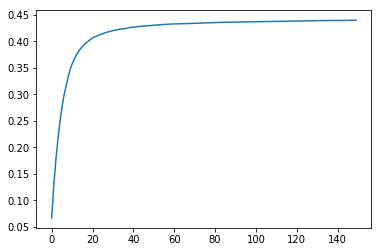

In [30]:
plt.plot(gbr.oob_improvement_.cumsum())

In [31]:
feats_imp = pd.DataFrame({'cols': X_train.columns, 'imp': gbr.feature_importances_})
feats_imp.sort_values(by='imp', ascending=False, inplace=True)
feats_imp.head(20)

,cols,imp
68,ratio_s_w,0.078736
154,visitors_mv,0.067376
75,ratio_s_d,0.043291
71,median_s_d,0.033111
61,ratio_s_m,0.029682
17,median_visitors,0.029476
70,mean_s_d,0.028739
93,ratio_g_w,0.028722
5,doy,0.027305
6,date_int,0.026979


## Model and Predict #0.5 lightGBM

In [182]:
# train split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
# kfold
kf = KFold(n_splits=5, shuffle=True)
lgbr = LGBMRegressor()

num = 1
scores = []
for train_idx, test_idx in tqdm_notebook(kf.split(X)):
    # print("Traing Fold#%d" % num)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    lgbr.fit(X_train, y_train)
    y_pred = lgbr.predict(X_test)
    scores.append(RMSLE(y_test, y_pred))
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    num += 1

print(scores)

A Jupyter Widget


[0.45258560763551137, 0.449389197042478, 0.45144964658894904, 0.4494732277202956, 0.4492056679589524]


In [52]:
# train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
# kfold
kf = KFold(n_splits=5, shuffle=True)

params = {
    'num_leaves': [50, 80],
    'learning_rate': [0.05, 0.1, 0.3],
    'n_estimators': [200, 250, 300, 350, 400],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
    # 'min_samples_split': [200,],
    # 'min_samples_leaf': [20,]
    }

lgbr = LGBMRegressor()
model0 = GridSearchCV(lgbr, params, cv=kf , scoring=rmsle_score, verbose=3)
model0.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.4508300275400348, total=  28.1s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.6s remaining:    0.0s


[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.4485163575635153, total=  24.7s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.45111819067141384, total=  27.2s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.4507694355492065, total=  26.3s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.45263641389286485, total=  26.2s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.8, score=-0.4493663651971861, total=  30.7s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=200, num_

[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.4486021960482672, total=  35.2s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.4508429507602654, total=  35.0s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1, score=-0.4487015973775173, total=  35.9s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1, score=-0.44659756631112985, total=  36.0s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=250, num_leaves=50, 

[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=300, num_leaves=50, subsample=1, score=-0.45026095140706496, total=  39.5s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.44917666312424803, total=  40.3s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.4475152790553632, total=  40.4s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.44944794308551544, total=  39.4s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=300, num_l

[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.44725814055876356, total=  51.3s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.44562216191076154, total=  51.6s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.44718178403330416, total=  51.9s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.4473053385974947, total=  51.3s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=350, num

[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=400, num_leaves=80, subsample=1, score=-0.4449437841994048, total=  56.0s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=400, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=400, num_leaves=80, subsample=1, score=-0.44630875948711585, total=  56.8s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=400, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=400, num_leaves=80, subsample=1, score=-0.4464237888427673, total=  56.3s
[CV] colsample_bytree=0.5, learning_rate=0.05, n_estimators=400, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.05, n_estimators=400, num_leaves=80, subsample=1, score=-0.44874411740046166, total=  56.1s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=200, num_leaves=50, subsa

[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.5, score=-0.4515527608369073, total=  27.7s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.5, score=-0.4505252132864187, total=  27.5s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.5, score=-0.4532143795470301, total=  27.8s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.44921132116905726, total=  30.2s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=250, num_leaves=50,

[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=300, num_leaves=50, subsample=0.8, score=-0.44873164852796027, total=  33.9s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=300, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=300, num_leaves=50, subsample=0.8, score=-0.45153232516172076, total=  34.0s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=300, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=300, num_leaves=50, subsample=1, score=-0.44682397568304144, total=  34.0s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=300, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=300, num_leaves=50, subsample=1, score=-0.4462255132180727, total=  33.6s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=300, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=300, num_leaves=50, subsamp

[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=350, num_leaves=50, subsample=1, score=-0.4491800994726441, total=  37.5s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.5, score=-0.4555521550815251, total=  41.8s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.5, score=-0.45237077659835373, total=  41.4s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.5, score=-0.4558156282634642, total=  41.3s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=350, num_leaves=80, s

[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=0.8, score=-0.45104692008856334, total=  49.2s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=0.8, score=-0.44920353814319186, total=  49.2s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=0.8, score=-0.4511061397178116, total=  48.8s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=0.8, score=-0.4507899637539832, total=  48.5s
[CV] colsample_bytree=0.5, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.1, n_estimators=400, num_leaves=80

[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=200, num_leaves=80, subsample=1, score=-0.4572919928129865, total=  25.5s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=200, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=200, num_leaves=80, subsample=1, score=-0.4606049597877669, total=  25.2s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=200, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=200, num_leaves=80, subsample=1, score=-0.45895501777411835, total=  25.7s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=200, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=200, num_leaves=80, subsample=1, score=-0.46245652078937777, total=  24.8s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.

[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=0.5, score=-0.47558489123541775, total=  29.9s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=0.5, score=-0.47528098390557444, total=  29.6s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=0.5, score=-0.47897293798228235, total=  30.4s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=0.8, score=-0.46349395322165454, total=  29.8s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=300, num_leaves=

[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=350, num_leaves=50, subsample=0.8, score=-0.4661027759848792, total=  34.4s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=350, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=350, num_leaves=50, subsample=0.8, score=-0.4700474764734353, total=  34.4s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=350, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=350, num_leaves=50, subsample=1, score=-0.45923860356494667, total=  32.3s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=350, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=350, num_leaves=50, subsample=1, score=-0.45845066575318005, total=  33.1s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=350, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=350, num_leaves=50, subsampl

[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=400, num_leaves=50, subsample=1, score=-0.4652821049345979, total=  35.7s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=0.5, score=-0.49508447911182996, total=  46.3s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=0.5, score=-0.4938429788582784, total=  45.0s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=0.5, score=-0.4951706280050643, total=  45.7s
[CV] colsample_bytree=0.5, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.5, learning_rate=0.3, n_estimators=400, num_leaves=80, s

[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num_leaves=80, subsample=0.8, score=-0.44688279309073975, total=  37.1s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num_leaves=80, subsample=0.8, score=-0.44495524110349716, total=  37.4s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num_leaves=80, subsample=0.8, score=-0.44690452267015934, total=  37.4s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num_leaves=80, subsample=0.8, score=-0.4473973056652019, total=  36.8s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=200, num

[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=250, num_leaves=80, subsample=1, score=-0.44431764374824756, total=  42.7s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=250, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=250, num_leaves=80, subsample=1, score=-0.44594424627093027, total=  43.0s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=250, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=250, num_leaves=80, subsample=1, score=-0.4466336766517027, total=  42.8s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=250, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=250, num_leaves=80, subsample=1, score=-0.44871448648357753, total=  42.6s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=300, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=300, num_leaves=50, su

[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=350, num_leaves=50, subsample=0.5, score=-0.44864354671125634, total=  39.4s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=350, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=350, num_leaves=50, subsample=0.5, score=-0.44854931379560514, total=  39.0s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=350, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=350, num_leaves=50, subsample=0.5, score=-0.4502077254983413, total=  39.6s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=350, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=350, num_leaves=50, subsample=0.8, score=-0.4465402411663325, total=  44.0s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=350, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=350, num_

[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=400, num_leaves=50, subsample=0.8, score=-0.4468776115361723, total=  47.1s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=400, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=400, num_leaves=50, subsample=0.8, score=-0.44913194571862247, total=  47.1s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=400, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=400, num_leaves=50, subsample=1, score=-0.44620326175000624, total=  48.5s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=400, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=400, num_leaves=50, subsample=1, score=-0.44483614645605596, total=  49.5s
[CV] colsample_bytree=0.8, learning_rate=0.05, n_estimators=400, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.05, n_estimators=400, num_leaves=50

[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=1, score=-0.4493450703200707, total=  26.7s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=200, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=200, num_leaves=80, subsample=0.5, score=-0.4517306390699194, total=  28.5s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=200, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=200, num_leaves=80, subsample=0.5, score=-0.44916644697271896, total=  28.5s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=200, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=200, num_leaves=80, subsample=0.5, score=-0.45085358693497934, total=  28.3s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=200, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=200, num_leaves=80, 

[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=250, num_leaves=80, subsample=0.8, score=-0.44832914893374226, total=  35.8s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=250, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=250, num_leaves=80, subsample=0.8, score=-0.4462307060718576, total=  35.8s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=250, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=250, num_leaves=80, subsample=0.8, score=-0.44761142454355446, total=  35.8s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=250, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=250, num_leaves=80, subsample=0.8, score=-0.4477488736593042, total=  36.0s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=250, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=250, num_leaves=80

[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=1, score=-0.44548361245973467, total=  40.3s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=1, score=-0.447306342576965, total=  40.0s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=1, score=-0.44796155788212266, total=  40.0s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=1, score=-0.4501295463576324, total=  40.6s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=350, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=350, num_leaves=50, subsample=0.5

[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=400, num_leaves=50, subsample=0.5, score=-0.4524154931069386, total=  40.3s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=400, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=400, num_leaves=50, subsample=0.5, score=-0.45249347728836503, total=  40.2s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=400, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=400, num_leaves=50, subsample=0.5, score=-0.4545759052091813, total=  40.1s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=400, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=400, num_leaves=50, subsample=0.8, score=-0.4482935494662902, total=  42.2s
[CV] colsample_bytree=0.8, learning_rate=0.1, n_estimators=400, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.1, n_estimators=400, num_leaves=50,

[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=0.8, score=-0.4582761512024018, total=  23.4s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=0.8, score=-0.4610009054026842, total=  23.6s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=1, score=-0.45545900811952045, total=  22.8s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=1, score=-0.45243462682181773, total=  22.7s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=200, num_leaves=50, subsampl

[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=1, score=-0.4588123919098238, total=  25.3s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=250, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=250, num_leaves=80, subsample=0.5, score=-0.48374788103940014, total=  31.7s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=250, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=250, num_leaves=80, subsample=0.5, score=-0.48132853788238855, total=  32.0s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=250, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=250, num_leaves=80, subsample=0.5, score=-0.4839806219302219, total=  31.5s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=250, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=250, num_leaves=80, 

[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.8, score=-0.4735481051850384, total=  35.8s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.8, score=-0.4720527420514863, total=  35.8s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.8, score=-0.47249950157303966, total=  36.0s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.8, score=-0.4719354425054572, total=  35.6s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=300, num_leaves=80,

[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=1, score=-0.46437280243861345, total=  38.1s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=1, score=-0.4674971731075493, total=  37.9s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=1, score=-0.466810667027227, total=  37.4s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=1 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=1, score=-0.47089852749461486, total=  37.5s
[CV] colsample_bytree=0.8, learning_rate=0.3, n_estimators=400, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=0.8, learning_rate=0.3, n_estimators=400, num_leaves=50, subsample=0.5

[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.4489513217534392, total=  26.9s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.4498818039467861, total=  26.5s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.45129173461491534, total=  26.9s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.8, score=-0.44813367817297983, total=  30.6s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=200, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=200, num_leaves=50, subsamp

[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.44943439453465944, total=  35.9s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1, score=-0.4475484526608709, total=  36.1s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1, score=-0.4460352302934512, total=  34.8s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1, score=-0.4476239659566483, total=  35.2s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=250, num_leaves=50, subsample=1, score=-0.

[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.4462847680388428, total=  41.8s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.44793052187663174, total=  41.9s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.4487201017543942, total=  41.6s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.4505924353012299, total=  42.0s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=300, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=300, num_leaves=80, subsampl

[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.4460562806245997, total=  52.1s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.4487360741602826, total=  52.6s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=1, score=-0.4462481931455427, total=  52.5s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=1, score=-0.44375217276869944, total=  52.3s
[CV] colsample_bytree=1, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.05, n_estimators=350, num_leaves=80, subsample=1, score

[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.45040239084316386, total=  24.3s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.4482205351586858, total=  24.2s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.44998325491334923, total=  23.9s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.44948000490141393, total=  24.3s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=200, num_leaves=50, subsample=0.5, 

[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.4467918175407833, total=  30.7s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.44771774115423313, total=  30.4s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.4495222507602553, total=  30.5s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=1, score=-0.4468651428075192, total=  30.2s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=250, num_leaves=50, subsample=1, score=-0.4

[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=300, num_leaves=50, subsample=1, score=-0.44937767553927943, total=  34.0s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.45315328822920153, total=  38.6s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.45101277996211625, total=  38.6s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.4533326079826021, total=  38.8s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=300, num_leaves=80, subsample=0.5, sc

[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.4473230082490303, total=  46.3s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.44906775092721557, total=  45.9s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.449172582127476, total=  45.4s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.45284105280241754, total=  45.5s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=350, num_leaves=80, subsample=1, score=

[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=1, score=-0.4482699853968043, total=  49.1s
[CV] colsample_bytree=1, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.1, n_estimators=400, num_leaves=80, subsample=1, score=-0.4511625653502133, total=  48.2s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.46778808993394555, total=  22.4s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=0.5, score=-0.46642334533248525, total=  22.5s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=200, num_leaves=50, subsample=0.5, score=-

[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.46352970101097823, total=  27.0s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.45986453930153964, total=  26.6s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.46131184838897776, total=  26.7s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.8, score=-0.46071815058779014, total=  26.9s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=250, num_leaves=50, subsample=0.8,

[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=1, score=-0.4580145832482086, total=  29.5s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=1, score=-0.4570883299550143, total=  28.9s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=300, num_leaves=50, subsample=1, score=-0.4604080701456302, total=  29.1s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.48982076918762946, total=  37.8s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.5 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=300, num_leaves=80, subsample=0.5, score=-0.486

[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=0.5, score=-0.4959099139152155, total=  43.3s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.47613384101286543, total=  41.5s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.47501308361398803, total=  41.3s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=0.8, score=-0.474985469440477, total=  41.6s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=0.8 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=350, num_leaves=80, subsample=0.8, sc

[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=1, score=-0.46710628348821365, total=  42.5s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=1, score=-0.46927063618386056, total=  43.4s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=1, score=-0.47059465200267175, total=  42.5s
[CV] colsample_bytree=1, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=1 
[CV]  colsample_bytree=1, learning_rate=0.3, n_estimators=400, num_leaves=80, subsample=1, score=-0.47230310187738955, total=  42.6s


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 969.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'num_leaves': [50, 80], 'learning_rate': [0.05, 0.1, 0.3], 'n_estimators': [200, 250, 300, 350, 400], 'subsample': [0.5, 0.8, 1], 'colsample_bytree': [0.5, 0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(RMSLE, greater_is_better=False), verbose=3)

In [47]:
model0.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
       n_jobs=-1, num_leaves=50, objective=None, random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=1)

In [56]:
model0.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.05,
 'n_estimators': 400,
 'num_leaves': 80,
 'subsample': 1}

In [184]:
model0 = pickle.load(open('best_lgbm.pkl', 'rb'))

In [185]:
# train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
# kfold
kf = KFold(n_splits=5, shuffle=True)

num = 1
scores = []
for train_idx, test_idx in tqdm_notebook(kf.split(X)):
    # print("Traing Fold#%d" % num)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model0.fit(X_train, y_train)
    y_pred = model0.predict(X_test)
    scores.append(RMSLE(y_test, y_pred))
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    num += 1
print(scores)

A Jupyter Widget


[0.4426554468041911, 0.4454676315481114, 0.4455032946832066, 0.44746809451313313, 0.45022132881112653]


#### KNeighborsRegressor

In [53]:
# train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)
# kfold
kf = KFold(n_splits=5, shuffle=True)

params = {
    'n_neighbors': range(1,11),
    'weights': ['uniform', 'distance']
    # 'min_samples_split': [200,],
    # 'min_samples_leaf': [20,]
    }

knr = KNeighborsRegressor()
model1 = GridSearchCV(knr, params, cv=kf , scoring=rmsle_score, verbose=3)
model1.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_neighbors=1, weights=uniform ..................................
[CV]  n_neighbors=1, weights=uniform, score=-0.7962436637742082, total=  45.8s
[CV] n_neighbors=1, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  n_neighbors=1, weights=uniform, score=-0.7985624531416565, total=  42.3s
[CV] n_neighbors=1, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s


[CV]  n_neighbors=1, weights=uniform, score=-0.798154016470842, total=  42.9s
[CV] n_neighbors=1, weights=uniform ..................................
[CV]  n_neighbors=1, weights=uniform, score=-0.8008398938793793, total=  42.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV]  n_neighbors=1, weights=uniform, score=-0.7983444422929494, total=  42.1s
[CV] n_neighbors=1, weights=distance .................................
[CV]  n_neighbors=1, weights=distance, score=-0.7962436637742082, total=  41.2s
[CV] n_neighbors=1, weights=distance .................................
[CV]  n_neighbors=1, weights=distance, score=-0.7985624531416566, total=  42.7s
[CV] n_neighbors=1, weights=distance .................................
[CV]  n_neighbors=1, weights=distance, score=-0.798154016470842, total=  43.0s
[CV] n_neighbors=1, weights=distance .................................
[CV]  n_neighbors=1, weights=distance, score=-0.8008398938793793, total=  42.2s
[CV] n_neighbors=1,

[CV]  n_neighbors=6, weights=distance, score=-0.6411071485590151, total=  48.8s
[CV] n_neighbors=6, weights=distance .................................
[CV]  n_neighbors=6, weights=distance, score=-0.6423307794082012, total=  48.3s
[CV] n_neighbors=6, weights=distance .................................
[CV]  n_neighbors=6, weights=distance, score=-0.6431329338353428, total=  48.3s
[CV] n_neighbors=7, weights=uniform ..................................
[CV]  n_neighbors=7, weights=uniform, score=-0.6238835771948616, total=  47.5s
[CV] n_neighbors=7, weights=uniform ..................................
[CV]  n_neighbors=7, weights=uniform, score=-0.6233293578904381, total=  48.7s
[CV] n_neighbors=7, weights=uniform ..................................
[CV]  n_neighbors=7, weights=uniform, score=-0.6238985712623744, total=  48.9s
[CV] n_neighbors=7, weights=uniform ..................................
[CV]  n_neighbors=7, weights=uniform, score=-0.6254551519231677, total=  48.4s
[CV] n_neighbors=7

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 222.3min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(RMSLE, greater_is_better=False), verbose=3)

In [54]:
model1.best_score_

-0.61946346594684309

In [57]:
model1.best_params_

{'n_neighbors': 10, 'weights': 'uniform'}

In [61]:
knr.fit

<bound method SupervisedFloatMixin.fit of KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')>

#### Linear Regression

In [33]:
# lr = Lasso(alpha=0.2, max_iter=2000)
lm = LinearRegression()
kf = KFold(n_splits=5)
num = 1
scores = []
for train_idx, test_idx in tqdm_notebook(kf.split(X)):
    # print("Traing Fold#%d" % num)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    scores.append(RMSLE(y_test, y_pred))
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    num += 1

print(scores)

A Jupyter Widget


[0.48462267433198497, 0.4771441900118402, 0.44903597860557565, 0.4473329688398815, 0.45611544444715507]


In [144]:
scores

[0.5043992514811342,
 0.4983335624223458,
 0.467356329439852,
 0.4677429003978038,
 0.4769944674927833]

In [34]:
print(np.mean(scores))

0.4628502512472875


#### Linear Regression on X_rfe

In [40]:
# lr = Lasso(alpha=0.2, max_iter=2000)
lm = LinearRegression()
kf = KFold(n_splits=5)
num = 1
scores = []
for train_idx, test_idx in tqdm_notebook(kf.split(X_rfe)):
    # print("Traing Fold#%d" % num)
    X_train, X_test = X_rfe[train_idx], X_rfe[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
    scores.append(RMSLE(y_test, y_pred))
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    num += 1

print(scores)

A Jupyter Widget


[0.48747733459747733, 0.4795018222641172, 0.4512932154316208, 0.44943540544580574, 0.4588590973783199]


In [41]:
print(np.mean(scores))

0.4653133750234682


#### STACKING

In [76]:
import pickle

pickle.dump(model0.best_estimator_, open('best_lgbm.pkl', 'wb'))
pickle.dump(model1.best_estimator_, open('best_knr.pkl', 'wb'))
pickle.dump(lm, open('liean_model.pkl', 'wb'))

In [188]:
lgbr = pickle.load(open('best_lgbm.pkl', 'rb'))
lgbr.fit(X, y)
y_pred0 = lgbr.predict(test[col])

In [62]:
knr = model1.best_estimator_
knr.fit(X, y)
y_pred1 = knr.predict(test[col])

In [189]:
lm = LinearRegression()
lm.fit(X, y)
y_pred2 = lm.predict(test[col])

In [209]:
y_pred = ((y_pred0 * 0.6) + (y_pred2 * 0.4))

In [210]:
pd.DataFrame({'ID': data['tes'].id, 'visitors': np.expm1(y_pred)}).to_csv('submission0129-01.csv', index=False)

In [192]:
data['tes'].shape

(32019, 13)

## Model and Predict #1

In [83]:
# 辅助计时函数
def time_cnt(delta):
    total_secs = int(delta.total_seconds())
    format = '{h}H: {m}M: {s}S'
    h, m = total_secs // 3600, total_secs % 3600
    m, s = m // 60, m % 60
    return format.format(h=h, m=m, s=s)

In [84]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors', 'air_genre_name', 'air_area_name']]

time0 = datetime.now()
print("Modeling...")
model1 = GradientBoostingRegressor(learning_rate=0.2, random_state=3)
model2 = KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

print("Training...")
# model1
model1.fit(train[col], np.log1p(train['visitors'].values))
visitors_pred1 = model1.predict(train[col])
print("Time consume: ", time_cnt(datetime.now()-time0))

# model2
time0 = datetime.now()
model2.fit(train[col], np.log1p(train['visitors'].values))
visitors_pred2 = model2.predict(train[col])

print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), visitors_pred1))
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), visitors_pred2))
print("Time consume: ", time_cnt(datetime.now()-time0))

Modeling...
Training...
Time consume:  0H: 4M: 48S
RMSE GradientBoostingRegressor:  0.456443449301
RMSE KNeighborsRegressor:  0.489168172841
Time consume:  0H: 4M: 43S


## Model and Predict #2 Moving Average

In [152]:
visitors_mv.head()

,air_store_id,dow,holiday_flg,visitors_mv
0,air_00a91d42b08b08d9,0,0.0,3.203625
1,air_00a91d42b08b08d9,0,1.0,3.091042
2,air_00a91d42b08b08d9,1,0.0,3.325868
3,air_00a91d42b08b08d9,2,0.0,3.353439
4,air_00a91d42b08b08d9,3,0.0,3.475056


In [80]:
def mean_avg(tra, hol):
    air_visit_data = tra.copy()
    date_info = hol.copy()
    # 把周末的holiday_flag置为0
    date_info.loc[(date_info['visit_date'].dt.dayofweek>4) & date_info['holiday_flg']==1, :] = 0

    # 根据hol.index计算日期对应的权重weight
    date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5

    # 在visit_data中匹配日期weight
    visit_data = air_visit_data.merge(date_info, on='visit_date', how='left')

    # 将访问量转化为对数访问量log1p
    visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

    # 按照 air_store_id, dow, holiday_flg 的分组计算加权平均
    visitors = visit_data.groupby(['air_store_id', 'dow', 'holiday_flg']).apply(
        lambda x:( (x['weight'] * x['visitors']).sum() / x['weight'].sum() )).reset_index()
    visitors.rename(columns={0:'visitors'}, inplace=True) 
    return visitors

In [176]:
visitors_mv.head(2)

,air_store_id,dow,holiday_flg,visitors_mv
0,air_00a91d42b08b08d9,0,0.0,3.203625
1,air_00a91d42b08b08d9,0,1.0,3.091042


In [178]:
test.head()

,id,visitors,visit_date,air_store_id,dow,month,season,week,rs1_x,rv1_x,...,air_area_name5,air_area_name6,var_max_lat,var_max_long,lon_plus_lat,holiday_flg,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,visitors_mv
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,4,2,16,0.0,0.0,...,0,0,8.326629,4.519803,175.447598,0.0,0.0,0.0,0.0,1.098612
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,4,2,17,0.0,0.0,...,0,0,8.326629,4.519803,175.447598,0.0,0.0,0.0,0.0,3.203625
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,4,2,17,0.0,0.0,...,0,0,8.326629,4.519803,175.447598,0.0,0.0,0.0,0.0,3.325868
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,4,2,17,0.0,0.0,...,0,0,8.326629,4.519803,175.447598,0.0,0.0,0.0,0.0,3.353439
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,4,2,17,0.0,0.0,...,0,0,8.326629,4.519803,175.447598,0.0,0.0,0.0,0.0,3.475056


## 生成提交文件

In [74]:
sub1 = test[['id','visitors']].copy()
sub1['visitors'] = (model1.predict(test[col]) + model2.predict(test[col])) / 2
sub1['visitors'] = np.expm1(sub1['visitors']).clip(lower=0.)

In [75]:
sub2 = test[['id', 'visitors_mv']].copy()
sub2['visitors'] = sub2['visitors_mv'].map(pd.np.expm1)

In [197]:
sub2.head()

,id,visitors_mv,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.098612,2.000000
1,air_00a91d42b08b08d9_2017-04-24,3.203625,23.621632
2,air_00a91d42b08b08d9_2017-04-25,3.325868,26.823130
3,air_00a91d42b08b08d9_2017-04-26,3.353439,27.600920
4,air_00a91d42b08b08d9_2017-04-27,3.475056,31.299646


In [76]:
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')
sub_merge['visitors'] = (sub_merge['visitors_x'] + sub_merge['visitors_y']* 1.1)/2
sub_merge[['id', 'visitors']].to_csv('submission%s.csv' % datetime.now().strftime('%M%S'), index=False)